In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [3]:
transform = transforms.ToTensor()

traindata = torchvision.datasets.MNIST('./data/', download=False, transform=transform, train = True)

In [4]:
# Loading the training data
trainloader = torch.utils.data.DataLoader(traindata, shuffle=True, batch_size=64)

In [5]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid()
        )
        self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)

In [6]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid()
        )
        self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)

In [16]:
dataIter = iter(trainloader)
imgs, labels = dataIter.next()
Z_dim = 10    # dimension of the input noise for generator
H_dim = 128    # number of hidden neurons in our hidden layer
lr = 1e-3      # learning rate
X_dim = imgs.view(imgs.size(0), -1).size(1) #image size

In [17]:
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [18]:
G = Gen()
D = Dis()

In [19]:
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

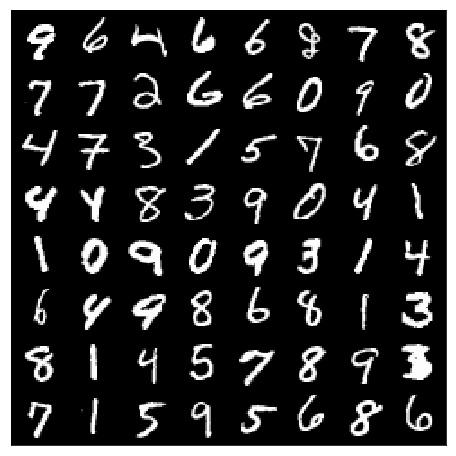

In [20]:
# Visualize a grid of imgs
def imshow(imgs):
    # make_grid will make a grid out of images
    imgs = torchvision.utils.make_grid(imgs)
    # transfoming tensors back to numpy 
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

imshow(imgs)

In [21]:
def energy(X):
    reconstructed_X = D(X)
    return torch.mean(torch.sum((X - reconstructed_X)**2, 1))

In [ ]:
m = 3

# training loop
for epoch in range(100):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i,data in enumerate(trainloader):
        X, _ = data
        X = X.view(X.size(0), -1)
        mb_size = X.size(0)
        
        # Definig labels for real (1s) and fake (0s) images
        one_labels = torch.ones(mb_size, 1)
        zero_labels = torch.zeros(mb_size, 1)
        
        # Random normal distribution for each image
        z = torch.randn(mb_size, Z_dim)
        
        # Defining the loss for Discriminator
        D_real_loss = energy(X)
        D_fake_loss = energy(G(z))
        D_loss = D_fake_loss + F.relu(m - D_real_loss)
        
        # backward propagation for discriminator
        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()
        
        # Feed forward for generator
        z = torch.randn(mb_size, Z_dim)
        G_loss = energy(G(z))
        
#         print(D_real_loss, D_fake_loss, D_loss, G_loss)
        
        # backward propagation for generator
        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    # printing loss after each epoch 
    print('Epoch:{},   G_loss:{},   D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1) ))
    
    # Plotting fake images generated by generator
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28)
    imshow(samples)